# Analysis — Gold 1‑minute bars

In [5]:
from pyspark.sql import SparkSession, Window, DataFrame as _DF
from pyspark.sql.functions import (
    col, lag, lead, log, avg, stddev_samp, when, abs as fabs,
    unix_timestamp, lit, count
)
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Start/attach Spark
spark = SparkSession.builder.appName("analysis-gold-1m").getOrCreate()

# Helper: break line across time gaps so matplotlib doesn't draw long diagonals
def break_on_gaps(x, y, max_gap_minutes=3):
    xx, yy = [], []
    for i, (t, val) in enumerate(zip(x, y)):
        if i>0:
            dt = (x[i] - x[i-1]).total_seconds()/60.0
            if dt > max_gap_minutes:
                xx.append(x[i-1]); yy.append(np.nan)
        xx.append(t)
        yy.append(np.nan if val is None else val)
    return xx, yy


In [7]:
# Parameters & conditional load
SYMBOL  = "XBT/USDT"
GOLD_1M = "../data/gold/bars_1m"
K       = 180   # bars to plot
Z       = 3.0   # anomaly threshold
N       = 30    # rolling minutes for baselines

g = spark.read.parquet(GOLD_1M)

g_sym = (g.where(col("symbol")==SYMBOL)
           .select("symbol","bar_start","open","high","low","close","vwap","volume")
           .withColumn("ts_s", unix_timestamp("bar_start")))
g_sym.orderBy(col("bar_start").desc()).show(3, False)


+--------+-------------------+--------+--------+--------+--------+--------+----------+----------+
|symbol  |bar_start          |open    |high    |low     |close   |vwap    |volume    |ts_s      |
+--------+-------------------+--------+--------+--------+--------+--------+----------+----------+
|XBT/USDT|2025-09-07 21:31:00|111139.5|111139.5|111139.5|111139.5|111139.5|0.00360344|1757305860|
|XBT/USDT|2025-09-07 21:30:00|111127.9|111127.9|111127.9|111127.9|111127.9|8.999E-5  |1757305800|
|XBT/USDT|2025-09-07 21:27:00|111116.4|111116.4|111116.4|111116.4|111116.4|0.00449946|1757305620|
+--------+-------------------+--------+--------+--------+--------+--------+----------+----------+
only showing top 3 rows



In [8]:
# Time-aware signals: z_ret, z_vol, gap_pct
w_order = Window.partitionBy("symbol").orderBy(col("ts_s"))

g1 = (g_sym
  .withColumn("prev_close", lag("close").over(w_order))
  .withColumn("ret", when(col("prev_close").isNotNull(), (col("close")/col("prev_close"))-1))
  .withColumn("logret", when(col("prev_close").isNotNull(), log(col("close")/col("prev_close"))))
)

secN = 60 * N
w_time = w_order.rangeBetween(-secN, -1)

stats = (g1
  .withColumn("ret_mu_N", avg("logret").over(w_time))
  .withColumn("ret_sd_N", stddev_samp("logret").over(w_time))
  .withColumn("z_ret", when((col("ret_sd_N").isNotNull()) & (col("ret_sd_N") > 1e-12),
                            (col("logret")-col("ret_mu_N"))/col("ret_sd_N")))
  .select("symbol","bar_start","z_ret")
)

vol = (g1
  .withColumn("vol_mu", avg("volume").over(w_time))
  .withColumn("vol_sd", stddev_samp("volume").over(w_time))
  .withColumn("z_vol", when((col("vol_sd").isNotNull()) & (col("vol_sd") > 1e-12),
                            (col("volume")-col("vol_mu"))/col("vol_sd")))
  .select("symbol","bar_start","z_vol","volume")
)

gaps = (g1
  .withColumn("next_open", lead("open").over(w_order))
  .withColumn("gap_pct", when(col("next_open").isNotNull(),
                              (col("next_open")-col("close"))/col("close")))
  .select("symbol","bar_start","gap_pct")
)

alerts = (g1.select("symbol","bar_start","close","vwap","volume")
  .join(stats, ["symbol","bar_start"], "left")
  .join(vol,   ["symbol","bar_start"], "left")
  .join(gaps,  ["symbol","bar_start"], "left")
  .withColumn("is_return_anom", fabs(col("z_ret")) > Z)
  .withColumn("is_volume_anom", col("z_vol") > Z)
)

alerts.agg(count("*").alias("rows"),
           count("z_ret").alias("z_non_null"),
           count("z_vol").alias("zv_non_null")).show()


+----+----------+-----------+
|rows|z_non_null|zv_non_null|
+----+----------+-----------+
| 173|       166|        167|
+----+----------+-----------+



In [9]:
# Build plotting arrays from in-memory DataFrames (no pandas)
base = g_sym.select("symbol","bar_start","close","vwap","volume")

want_double = ["z_ret","z_vol","gap_pct"]
want_bool   = ["is_return_anom","is_volume_anom"]

take = ["symbol","bar_start"] + [c for c in want_double+want_bool if c in alerts.columns]
joined = base.join(alerts.select(*take), ["symbol","bar_start"], "left")

# add any missing expected columns with defaults
for c in want_double:
    if c not in joined.columns:
        joined = joined.withColumn(c, lit(None).cast("double"))
for c in want_bool:
    if c not in joined.columns:
        joined = joined.withColumn(c, lit(False))

plot_df_recent = joined.orderBy(col("bar_start").desc()).limit(K).orderBy("bar_start")
cols = ["bar_start","close","vwap","volume"] + want_double + want_bool
rows = list(plot_df_recent.select(*cols).toLocalIterator())

x_time = [r.bar_start for r in rows]
close  = [r.close for r in rows]
vwap   = [r.vwap for r in rows]
volume = [r.volume for r in rows]
z_ret  = [r.z_ret for r in rows]
z_vol  = [r.z_vol for r in rows]
gap_pct = [r.gap_pct for r in rows]
anom_r = [bool(getattr(r,'is_return_anom', False)) for r in rows]
anom_v = [bool(getattr(r,'is_volume_anom', False)) for r in rows]

print("Bars:", len(rows), "  z_ret non-null:", sum(1 for v in z_ret if v is not None))


Bars: 173   z_ret non-null: 166


### Plot 1 — Close vs VWAP with return anomaly markers

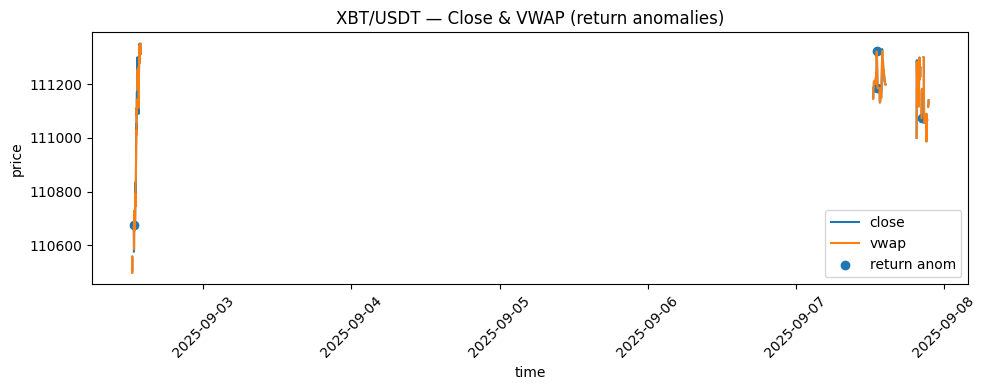

In [10]:
xx, yy_close = break_on_gaps(x_time, close)
_,  yy_vwap  = break_on_gaps(x_time, vwap)

plt.figure(figsize=(10,4))
plt.plot(xx, yy_close, label="close")
plt.plot(xx, yy_vwap,  label="vwap")
idx_r = [i for i,f in enumerate(anom_r) if f]
if idx_r:
    plt.scatter([x_time[i] for i in idx_r], [close[i] for i in idx_r], marker="o", label="return anom")
plt.title(f"{SYMBOL} — Close & VWAP (return anomalies)")
plt.xlabel("time"); plt.ylabel("price"); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


### Plot 2 — Volume (with anomalies)

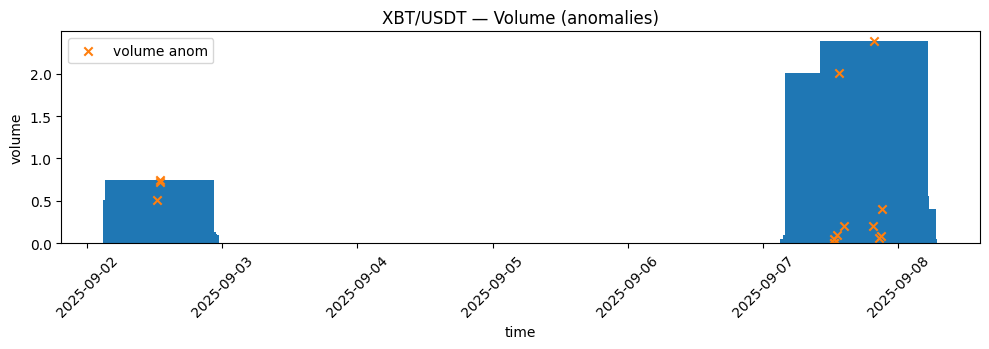

In [9]:
plt.figure(figsize=(10,3.6))
plt.bar(x_time, volume)
idx_v = [i for i,f in enumerate(anom_v) if f]
if idx_v:
    plt.scatter([x_time[i] for i in idx_v], [volume[i] for i in idx_v], marker="x", label="volume anom")
    plt.legend()
plt.title(f"{SYMBOL} — Volume (anomalies)")
plt.xlabel("time"); plt.ylabel("volume"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


### Plot 3 — Return z-score (±3)


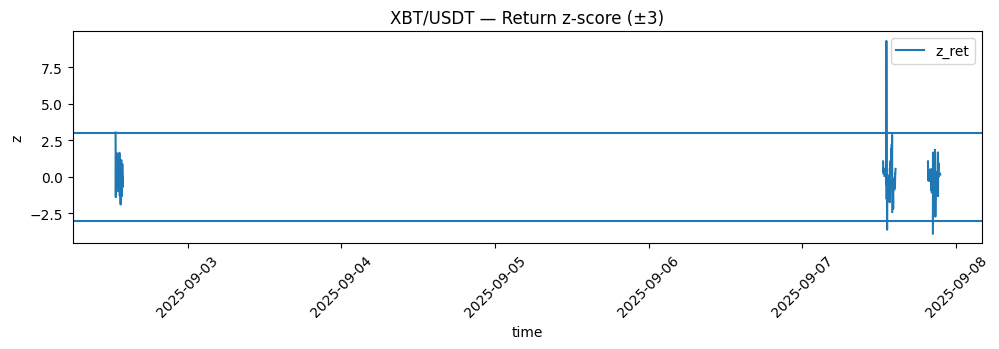

In [10]:
xx, yy_z = break_on_gaps(x_time, z_ret)
plt.figure(figsize=(10,3.6))
plt.plot(xx, yy_z, label="z_ret")
plt.axhline(3.0); plt.axhline(-3.0)
plt.title(f"{SYMBOL} — Return z-score (±3)")
plt.xlabel("time"); plt.ylabel("z"); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


### Plot 4 — Close -> Next Open gap (%)


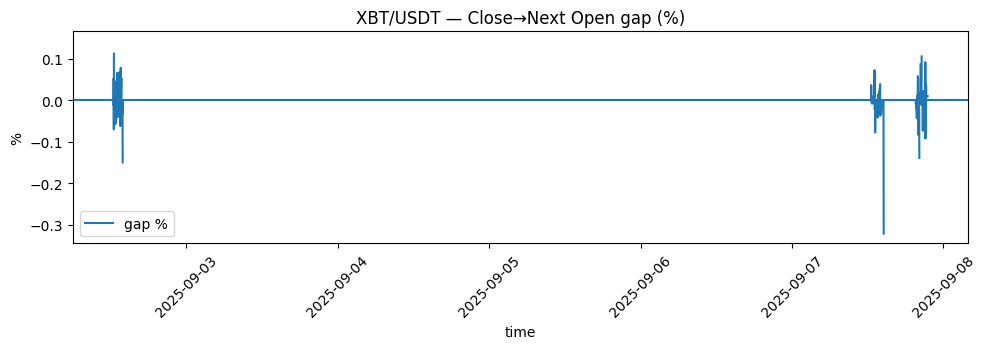

In [11]:
xx, yy_gap = break_on_gaps(x_time, [None if v is None else v*100.0 for v in gap_pct])
plt.figure(figsize=(10,3.6))
plt.plot(xx, yy_gap, label="gap %")
plt.axhline(0.0)
plt.title(f"{SYMBOL} — Close→Next Open gap (%)")
plt.xlabel("time"); plt.ylabel("%"); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
